# **1. Synthetic Image Generation**

In [1]:
import os
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import numpy as np

os.makedirs("images/raw", exist_ok=True)

def generate_images(prompt, num_images=3, output_dir="images/raw"):
    """
    Generate synthetic images using Stable Diffusion based on a text prompt.

    Args:
        prompt (str): The text prompt to guide image generation
        num_images (int): Number of images to generate
        output_dir (str): Directory to save the generated images

    Returns:
        list: Paths to the generated images
    """
    print(f"Generating {num_images} images with prompt: '{prompt}'")


    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load the Stable Diffusion pipeline
    pipeline = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )
    pipeline = pipeline.to(device)


    if device == "cpu":
        pipeline.enable_attention_slicing()

    image_paths = []

    # Generate the specified number of images
    for i in range(num_images):

        image = pipeline(prompt, num_inference_steps=30).images[0]
        image_path = os.path.join(output_dir, f"generated_image_{i+1}.png")
        image.save(image_path)
        image_paths.append(image_path)

        print(f"Image {i+1}/{num_images} saved to {image_path}")

    return image_paths

if __name__ == "__main__":

    prompt = "a serene sunset over a futuristic city with floating buildings and flying vehicles"
    generated_images = generate_images(prompt, num_images=3)
    print(f"Successfully generated {len(generated_images)} images!")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Generating 3 images with prompt: 'a serene sunset over a futuristic city with floating buildings and flying vehicles'
Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Image 1/3 saved to images/raw/generated_image_1.png


  0%|          | 0/30 [00:00<?, ?it/s]

Image 2/3 saved to images/raw/generated_image_2.png


  0%|          | 0/30 [00:00<?, ?it/s]

Image 3/3 saved to images/raw/generated_image_3.png
Successfully generated 3 images!


# **2. Image Preprocessing**

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json

os.makedirs("images/processed", exist_ok=True)

def preprocess_images(image_paths, output_dir="images/processed", size=(224, 224),
                     normalize=True, grayscale=False):
    """
    Preprocess images for model input: resize, normalize, and optionally convert to grayscale.

    Args:
        image_paths (list): List of paths to the images to preprocess
        output_dir (str): Directory to save the preprocessed images
        size (tuple): Target size for the images (width, height)
        normalize (bool): Whether to normalize pixel values to [0,1]
        grayscale (bool): Whether to convert images to grayscale

    Returns:
        list: Paths to the preprocessed images
        dict: Image metadata including tensor shapes and normalization info
    """
    processed_paths = []
    metadata = {
        "preprocessing_info": {
            "resize": size,
            "normalize": normalize,
            "grayscale": grayscale
        },
        "images": {}
    }

    for i, img_path in enumerate(image_paths):

        img = Image.open(img_path)
        img_resized = img.resize(size)

        if grayscale:
            img_processed = img_resized.convert('L')
            channels = 1
        else:
            img_processed = img_resized.convert('RGB')
            channels = 3

        img_array = np.array(img_processed)

        if normalize:
            img_array = img_array.astype(np.float32) / 255.0

        filename = os.path.basename(img_path)
        base_name = os.path.splitext(filename)[0]
        processed_filename = f"processed_{base_name}.npy"
        processed_path = os.path.join(output_dir, processed_filename)

        np.save(processed_path, img_array)
        processed_paths.append(processed_path)

        plt.figure(figsize=(10, 5))

        # Plot original(raw) image
        plt.subplot(1, 2, 1)
        plt.title("Original")
        plt.imshow(np.array(img))
        plt.axis('off')

        # Plot processed image
        plt.subplot(1, 2, 2)
        plt.title("Processed")
        if grayscale:
            plt.imshow(img_array, cmap='gray')
        else:
            # For normalized images, we need to ensure proper display
            if normalize:
                plt.imshow(img_array)
            else:
                plt.imshow(img_array.astype(np.uint8))
        plt.axis('off')

        vis_path = os.path.join(output_dir, f"vis_{base_name}.png")
        plt.savefig(vis_path)
        plt.close()

        # Here we add to metadata
        metadata["images"][processed_filename] = {
            "original_path": img_path,
            "processed_path": processed_path,
            "visualization_path": vis_path,
            "tensor_shape": img_array.shape,
            "channels": channels
        }

        print(f"Processed image {i+1}/{len(image_paths)}: {processed_path}")

    metadata_path = os.path.join(output_dir, "preprocessing_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)

    return processed_paths, metadata

if __name__ == "__main__":

    image_dir = "images/raw"
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                  if f.endswith(('.png', '.jpg', '.jpeg'))]

    if not image_paths:
        print("No images found in the 'images/raw' directory. Run image_generation.py first.")
    else:
        processed_paths, metadata = preprocess_images(
            image_paths,
            size=(224, 224),
            normalize=True,
            grayscale=False
        )

        print(f"Successfully preprocessed {len(processed_paths)} images!")
        print(f"Metadata saved to {os.path.join('images/processed', 'preprocessing_metadata.json')}")

Processed image 1/3: images/processed/processed_generated_image_3.npy
Processed image 2/3: images/processed/processed_generated_image_2.npy
Processed image 3/3: images/processed/processed_generated_image_1.npy
Successfully preprocessed 3 images!
Metadata saved to images/processed/preprocessing_metadata.json


# **3.Minimal Flux Model: Forward Pass Demonstration**

In [ ]:
using Flux
using Metalhead
using Images
using NPZ
using JSON
using Random
using Statistics
using BSON: @save, @load

"""
    load_preprocessed_image(filepath)

Load a preprocessed image from a .npy file and prepare it for Flux model input.
"""
function load_preprocessed_image(filepath)

    img_array = npzread(filepath)

    if length(size(img_array)) == 2
        img_tensor = reshape(img_array, size(img_array)..., 1, 1)
    else
        img_tensor = permutedims(img_array, (1, 2, 3, 4))
        img_tensor = reshape(img_array, size(img_array)..., 1)
    end

    return img_tensor
end

"""
    create_simple_model(input_channels=3)

Create a simple convolutional neural network model for image processing.
"""
function create_simple_model(input_channels=3)
    model = Chain(

        Conv((3, 3), input_channels => 16, relu; pad=1),
        MaxPool((2, 2)),

        Conv((3, 3), 16 => 32, relu; pad=1),
        MaxPool((2, 2)),

        Flux.flatten,

        Dense(32 * 56 * 56 => 10),
        softmax
    )

    return model
end

"""
    forward_pass(model, image_tensor)

Perform a forward pass through the model using the provided image tensor.
"""
function forward_pass(model, image_tensor)

    println("Input image tensor shape: ", size(image_tensor))
    output = model(image_tensor)

    println("Output tensor shape: ", size(output))
    println("Model prediction (raw): ", output)

    # Get the most likely class (highest probability)
    best_class = argmax(output) - 1
    println("Predicted class index: ", best_class)

    return output
end

"""
    main()

Main function to run the Flux forward pass demonstration.
"""
function main()
    metadata_path = joinpath("images", "processed", "preprocessing_metadata.json")
    if !isfile(metadata_path)
        error("Metadata file not found. Please run the image preprocessing script first.")
    end

    metadata = JSON.parsefile(metadata_path)

    image_files = collect(keys(metadata["images"]))
    if length(image_files) == 0
        error("No processed images found in metadata.")
    end

    selected_image = image_files[1]
    image_info = metadata["images"][selected_image]
    image_path = image_info["processed_path"]

    println("Selected image: ", selected_image)
    println("Original path: ", image_info["original_path"])
    println("Processed path: ", image_path)
    println("Tensor shape: ", image_info["tensor_shape"])

    # Load the preprocessed image
    println("\nLoading preprocessed image...")
    image_tensor = load_preprocessed_image(image_path)

    # Create a simple model
    println("\nCreating a simple convolutional neural network model...")
    channels = image_info["channels"]
    model = create_simple_model(channels)

    println("\nModel architecture:")
    for (i, layer) in enumerate(model)
        println("Layer $i: $(typeof(layer))")
    end

    # Perform forward pass
    println("\nPerforming forward pass...")
    output = forward_pass(model, image_tensor)

    model_path = "simple_flux_model.bson"
    @save model_path model
    println("\nModel saved to ", model_path)

    return model, output
end

model, output = main()

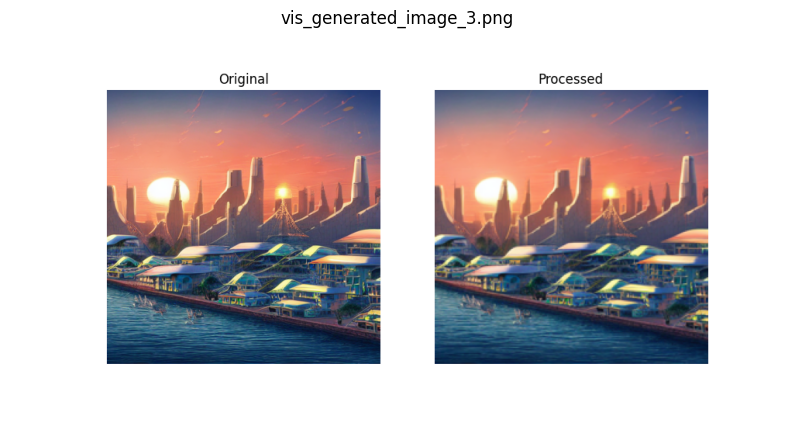

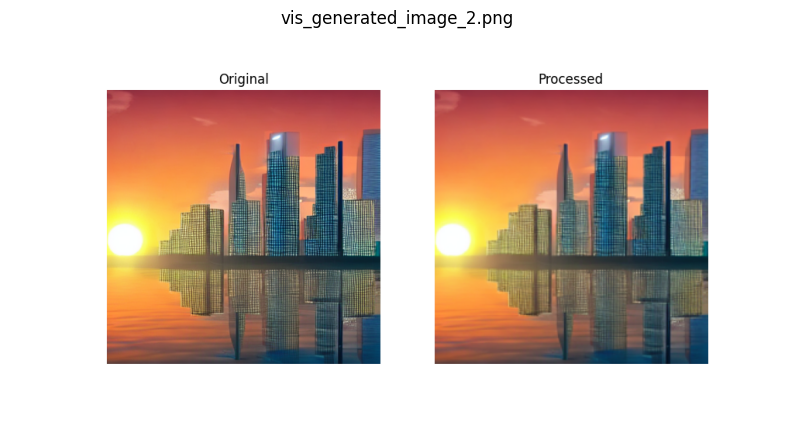

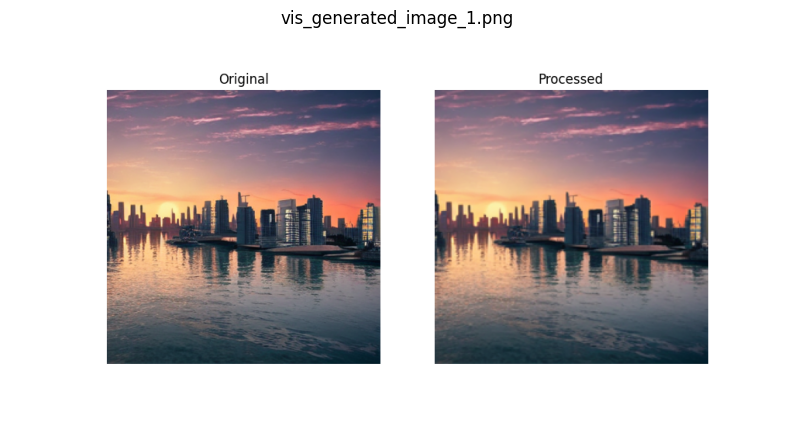

In [11]:
# Display the original and processed images
import matplotlib.pyplot as plt
import glob
import os

processed_vis = glob.glob("images/processed/vis_*.png")
for img_path in processed_vis:
    plt.figure(figsize=(10, 6))
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
    plt.show()